# Análise dos Microdados do Enem

**Contexto da análise do trabalho:** Análise do impacto da COVID-19 nos números da região Centro-oeste referente aos anos de 2018 a 2022.

**Onde encontrar os dados:** [Dados do Enem - INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem)

**Abaixo se encontra a importação das bibliotecas e carregamento dos dados**

Anteriormente, a limpeza dos dados foi realizada, resultando no arquivo 'ENEM_CO_TRATADO.parquet'.
Este arquivo será o foco de nossas análises.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import scipy.stats as stats
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats

dados_tratados = pd.read_parquet('ENEM_CO_TRATADO.parquet')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Tabelas "de-para"** são estruturas fundamentais em análise de dados e processamento de informações. Elas permitem a criação de associações entre valores originais e valores correspondentes, simplificando a interpretação e manipulação de dados complexos. Com funções específicas para cada tabela, como idade, cor/raça, nacionalidade, situação de conclusão, ano de conclusão e status de redação, podemos modularizar a criação dessas tabelas, tornando o código mais organizado e fácil de manter. Assim, o arquivo central pode importar essas funções prontas para uso, economizando tempo e facilitando a manipulação de dados em projetos analíticos. Essas tabelas são uma ferramenta valiosa para simplificar dados complexos e obter insights significativos de forma eficiente.

In [2]:
from tabelas_de_para import (
    criar_tabela_de_para_idades,
    criar_tabela_de_para_cor_raca,
    criar_tabela_de_para_nacionalidade,
    criar_tabela_de_para_situacao_conclusao,
    criar_tabela_de_para_ano_conclusao,
    criar_tabela_de_para_status_redacao
)

In [3]:
tabela_idades = criar_tabela_de_para_idades()
tabela_cor_raca = criar_tabela_de_para_cor_raca()
tabela_nacionalidade = criar_tabela_de_para_nacionalidade()
tabela_situacao_conclusao = criar_tabela_de_para_situacao_conclusao()
tabela_ano_conclusao = criar_tabela_de_para_ano_conclusao()
tabela_status_redacao = criar_tabela_de_para_status_redacao()

# Análise Exploratória das Variáveis
**Visualizações de algumas variáveis para possíveis insights.**

A função **mostrar_estatisticas()** recebe um DataFrame de dados como entrada e exibe estatísticas descritivas, incluindo média, desvio padrão, mínimo, 25º percentil, mediana, 75º percentil e máximo, para as colunas numéricas específicas do DataFrame. Ela formata a exibição dos números como floats com 2 casas decimais.


In [4]:
from estatisticas import mostrar_estatisticas
mostrar_estatisticas(dados_tratados)

,NU_NOTA_REDACAO,NU_NOTA_GERAL,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
count,1760255.00,1760255.00,1760255.00,1760255.00,1760255.00,1760255.00
mean,350.04,301.34,286.40,329.25,323.25,307.45
std,315.56,261.81,249.28,266.09,258.19,273.35
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00
50%,400.00,439.45,407.90,445.90,457.30,410.80
75%,600.00,522.15,497.10,556.20,541.50,530.00
max,1000.00,848.77,869.60,862.60,810.20,996.10


Este código calcula o tamanho necessário de uma amostra representativa de uma população significativa com 1.760.255 entradas. A abordagem adotada considera uma margem de erro de 2% e um nível de confiança de 99%, resultando em um valor crítico de Z de 2,575. Como a distribuição da população é desconhecida, foi escolhido um valor conservador de 0,5 como proporção.

A fórmula utilizada para calcular o tamanho da amostra é apresentada abaixo:

$$
n = \frac{{Z^2 \cdot P \cdot (1 - P)}}{{E^2}}
$$

Nesta equação, "n" representa o tamanho da amostra necessário, "Z" é o valor crítico de 2,575, "P" é a proporção conservadora de 0,5 e "E" é a margem de erro desejada de 2%. Essa abordagem visa obter uma amostra representativa da população, permitindo análises estatísticas mais precisas.


In [5]:
valor_critico_z = 2.575
proporcao_conservadora = 0.5
margem_de_erro = 0.02

tamanho_amostra = (((valor_critico_z**2) * proporcao_conservadora *
                   (1 - proporcao_conservadora)) / (margem_de_erro**2)) // 1 + 1

print("Tamanho da amostra necessário:", tamanho_amostra)


Tamanho da amostra necessário: 4145.0


Definimos o tamanho da amostra desejada como "tamanho_amostra" e usamos uma semente (seed) de 123 para garantir a reprodutibilidade dos resultados.

A amostra é criada a partir dos "dados_tratados" usando a função "sample()" do pandas, e o resultado é armazenado na variável "amostra_aleatoria".


In [6]:
amostra_aleatoria = dados_tratados.sample(n=int(tamanho_amostra), random_state=123)


## Análise de Inscritos
A análise de inscritos tem como objetivo investigar a relação entre o número de inscritos e a presença no ENEM ao longo dos anos, no período de 2018 a 2022.

#### Faixa Etária dos Inscritos no ENEM entre 2018 e 2022

Neste contexto, o código realiza uma análise da faixa etária dos alunos inscritos no ENEM entre 2018 e 2022. Ele começa criando um DataFrame que registra a contagem de alunos por faixa etária. Em seguida, esse DataFrame é combinado com um mapeamento das descrições das faixas etárias para facilitar a compreensão dos resultados. Por fim, o gráfico de barras exibe as quantidades de inscritos e presentes por ano, ajudando a visualizar a evolução ao longo do período analisado.

A seguir, apresentaremos o código responsável pela análise e a geração do gráfico.

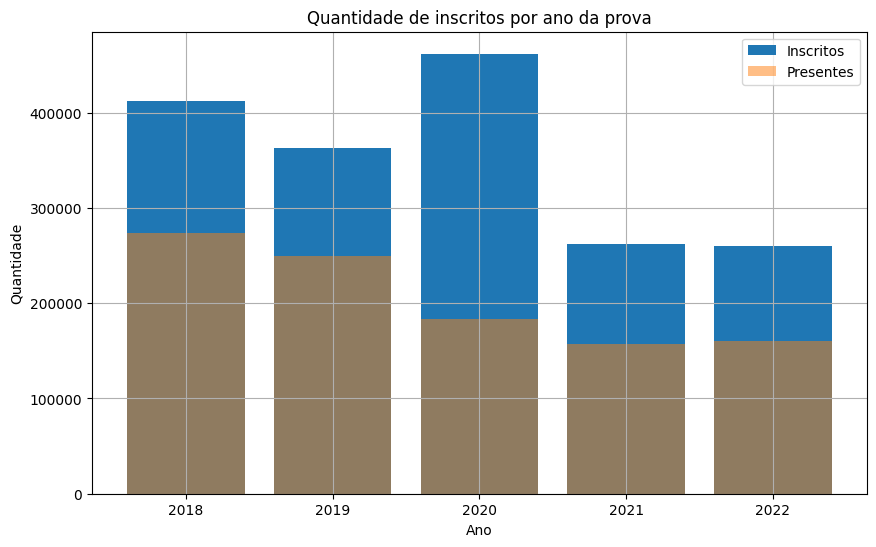

In [7]:
# Contagem de inscritos por ano
inscritos_por_ano = dados_tratados['NU_ANO'].value_counts().sort_index()

# Contagem de presentes por ano
presentes_por_ano = dados_tratados[dados_tratados['TP_PRESENCA'] == True]['NU_ANO'].value_counts().sort_index()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(inscritos_por_ano.index, inscritos_por_ano.values, label='Inscritos')
plt.bar(presentes_por_ano.index, presentes_por_ano.values, label='Presentes', alpha=0.5)  # Barras transparentes para presentes
plt.title('Quantidade de inscritos por ano da prova')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.grid(True)

# Adicionar a legenda
plt.legend()

plt.show()


#### Como a faixa etária dos inscritos mudou ao longo da pandemia?
Neste código, realizamos uma análise da distribuição da quantidade de alunos por faixa etária ao longo dos anos, no período de 2018 a 2022, incluindo o impacto da pandemia da COVID-19.

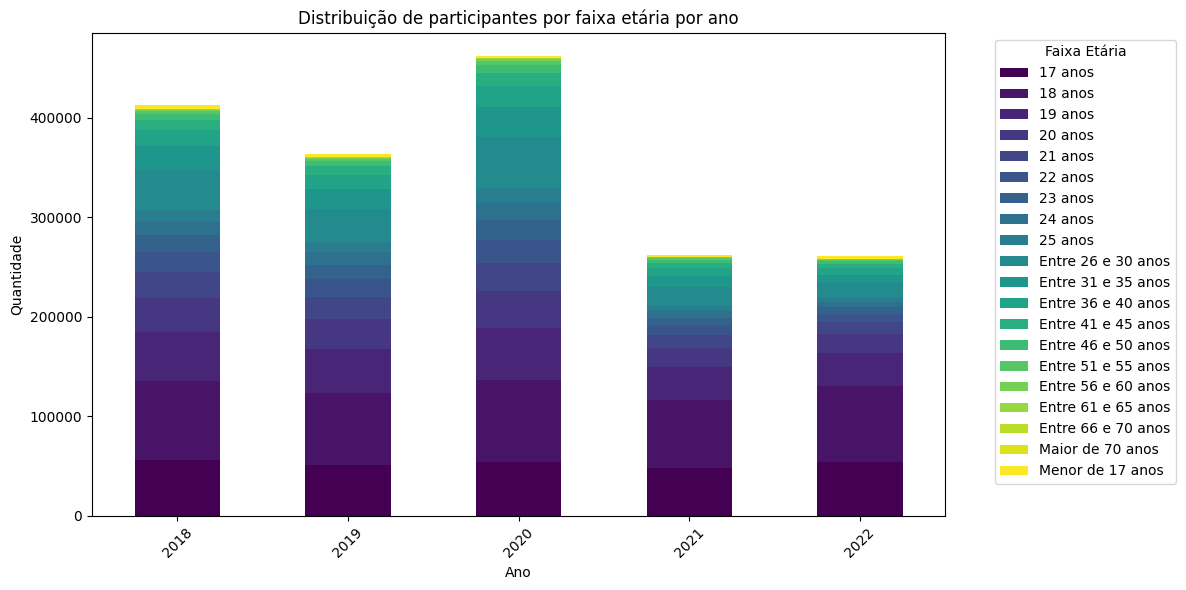

In [8]:
# Mesclar os dados de faixa etária com os dados tratados
faixa_etaria_ano = dados_tratados.merge(criar_tabela_de_para_idades().reindex(), left_on='TP_FAIXA_ETARIA', right_index=True, how='left')
faixa_etaria_ano = faixa_etaria_ano[['faixa_etaria', 'NU_ANO']]

# Contagem de participantes por faixa etária e ano
contagem_faixa_etaria_ano = faixa_etaria_ano.groupby(['NU_ANO', 'faixa_etaria']).size().unstack().fillna(0)

# Criar o gráfico de barras empilhadas
ax = contagem_faixa_etaria_ano.plot(kind='bar', stacked=True, cmap='viridis', figsize=(12, 6))

# Configurações do gráfico
plt.title('Distribuição de participantes por faixa etária por ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)

# Mover a legenda para fora do gráfico
ax.legend(title='Faixa Etária', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Mostrar o gráfico
plt.show()


1. **Concentração de Participantes:**
   - A concentração de participantes em uma faixa etária é calculada como a proporção de participantes nessa faixa em relação ao total de participantes.
   
   - Fórmula: `concentracao = participantes_na_faixa / total_participantes`
   - Se `concentracao` for maior que 0,5 (50%), há uma concentração significativa de participantes na faixa etária.

2. **Teste de Normalidade:**
   - O teste de normalidade D'Agostino e Pearson é usado para verificar se as médias de idade dentro da faixa etária seguem uma distribuição normal.
   - O teste gera um p-valor.
   - Se `p_value_normality` for menor que o nível de significância (`nivel_significancia`), as médias de idade não estão normalizadas; caso contrário, estão normalizadas.



In [15]:
def analisar_tabela_idades(dados_idades, faixa_etaria_min, faixa_etaria_max, nivel_significancia=0.05):

    # Filtra as faixas etárias de interesse
    dados_filtrados = dados_idades.loc[
        (dados_idades.index >= faixa_etaria_min) & (
            dados_idades.index <= faixa_etaria_max)
    ]

    # Verifica se a concentração de participantes está entre as faixas etárias desejadas
    total_participantes = dados_idades['media_idade'].sum()
    participantes_na_faixa = dados_filtrados['media_idade'].sum()

    if participantes_na_faixa / total_participantes > 0.5:
        concentracao_message = f"Há uma concentração significativa de participantes entre {faixa_etaria_min} e {faixa_etaria_max} anos.\n"
    else:
        concentracao_message = "Não há uma concentração significativa de participantes nessa faixa etária.\n"

    # Realiza o teste de normalidade nas médias de idade se houver amostras suficientes
    if len(dados_filtrados) >= 8:
        _, p_value_normality = stats.normaltest(dados_filtrados['media_idade'])

        if p_value_normality < nivel_significancia:
            normalidade_message = "As médias de idade não estão normalizadas."
        else:
            normalidade_message = "As médias de idade estão normalizadas."
    else:
        normalidade_message = "Não há amostras suficientes para realizar o teste de normalidade."

    # Retorna a mensagem de análise com quebras de linha
    return f"{concentracao_message}{normalidade_message}"

print(analisar_tabela_idades(dados_idades, 17, 19))


Não há uma concentração significativa de participantes nessa faixa etária.
Não há amostras suficientes para realizar o teste de normalidade.


**Análise do Resultado**


1. **Concentração de Participantes**: O código verifica se há uma concentração significativa de participantes na faixa etária de 17 a 19 anos, com base nas médias de idade em relação ao total de participantes. O resultado obtido é que "Não há uma concentração significativa de participantes nessa faixa etária." Isso significa que, estatisticamente, a proporção de participantes entre 17 e 19 anos em relação ao total não é considerada significativamente maior do que 50%.

2. **Teste de Normalidade**: O código realiza um teste de normalidade (Anderson-Darling) nas médias de idade das faixas etárias de 17 a 19 anos. No entanto, para que o teste seja válido, é necessário ter um número mínimo de amostras disponíveis. O resultado obtido é que "Não há amostras suficientes para realizar o teste de normalidade." Isso significa que a quantidade de dados na faixa etária específica é tão pequena que não é possível concluir estatisticamente se a distribuição das idades nessa faixa etária segue uma distribuição normal.

Esses resultados podem não coincidir diretamente com a observação visual de um gráfico, uma vez que a análise estatística se baseia em critérios estatísticos rígidos e pode não refletir a concentração visualmente percebida de participantes nessa faixa etária.